In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Load dataxq
pd_data = pd.read_csv('../../datasets/kc_house_data.csv')

In [2]:

X = pd_data.drop(columns=['CRIM','NOX','B','MEDV','TAX',"INDUS","CHAS","RAD","ZN"])
y = pd_data['MEDV'] 

print(X.columns)



X.columns = [
    # 'Crime Rate',
    # '% Residential in Area', 
    # '% Business in Area', 
    # 'River', 
    # 'Air Pollution',
    '#Rooms',
    '% Pre-1940 Units',
    'Dist to Biz', 
    # 'Highway Accessibility',
    # 'Property Tax Rate',
    'Stu-Tea Ratio',
    '% Lower Income',
]

Index(['RM', 'AGE', 'DIS', 'PTRATIO', 'LSTAT'], dtype='object')


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# 训练测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练 RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test) 
r2_socre_ = r2_score(y_test, preds)
print(r2_socre_)
rmse_score = np.sqrt(np.mean((y_test - preds) ** 2))
print(rmse_score)

0.8511090923081788
3.3043506985814455


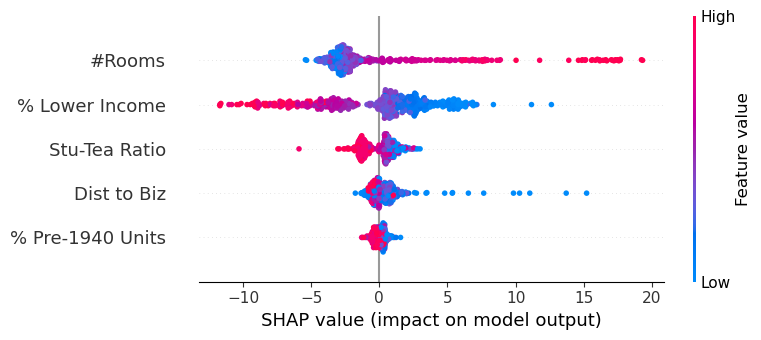

In [4]:
import shap
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values,X)

In [5]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)
ood_cluster = 0
ood_indices = np.where(cluster_labels == ood_cluster)[0]
in_dist_indices = np.where(cluster_labels != ood_cluster)[0]
# 3. Split in-distribution data into train/test
X_in, y_in = X.iloc[in_dist_indices], y.iloc[in_dist_indices]
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(X_in, y_in, test_size=0.2, random_state=42)

# 4. Train model on in-distribution data
rf_in = RandomForestRegressor(n_estimators=100, random_state=42)
rf_in.fit(X_train_in, y_train_in)

in_preds = rf.predict(X_test_in)
in_r2 = r2_score(y_test_in, in_preds)
in_rmse = np.sqrt(np.mean((y_test_in - in_preds)**2))

# 6. Evaluate on OOD cluster
X_ood, y_ood = X.iloc[ood_indices], y.iloc[ood_indices]
ood_preds = rf_in.predict(X_ood)
ood_r2 = r2_score(y_ood, ood_preds)
ood_rmse = np.sqrt(np.mean((y_ood - ood_preds)**2))

print(f"In-distribution R2: {in_r2:.3f}, RMSE: {in_rmse:.3f}")
print(f"OOD R2: {ood_r2:.3f}, RMSE: {ood_rmse:.3f}")

In-distribution R2: 0.956, RMSE: 1.351
OOD R2: 0.469, RMSE: 6.890


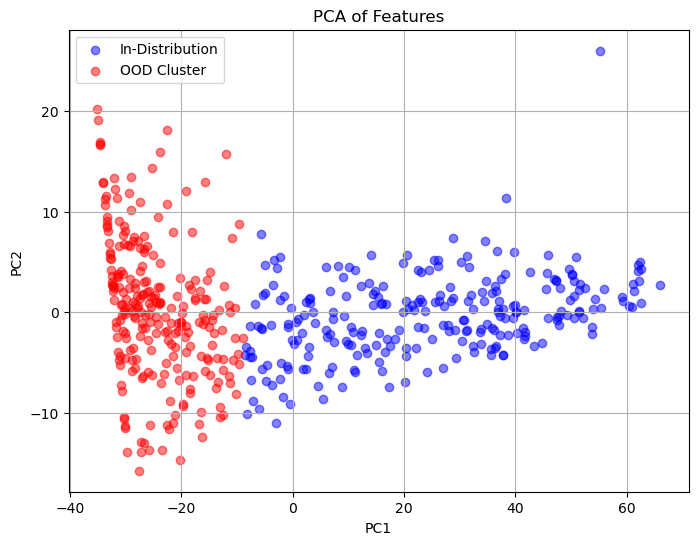

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[in_dist_indices, 0], X_pca[in_dist_indices, 1], c='blue', label='In-Distribution', alpha=0.5)
plt.scatter(X_pca[ood_indices, 0], X_pca[ood_indices, 1], c='red', label='OOD Cluster', alpha=0.5)
plt.legend()
plt.title("PCA of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [7]:
X_train.columns

Index(['#Rooms', '% Pre-1940 Units', 'Dist to Biz', 'Stu-Tea Ratio',
       '% Lower Income'],
      dtype='object')

In [8]:
print(len(in_dist_indices),len(ood_indices))

254 252


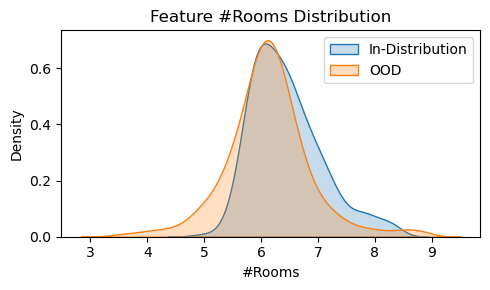

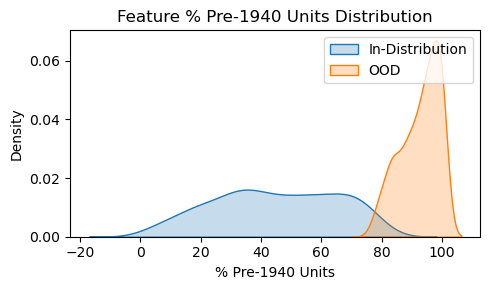

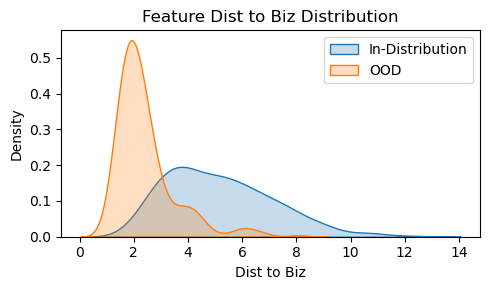

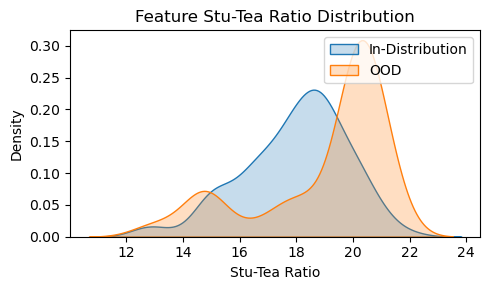

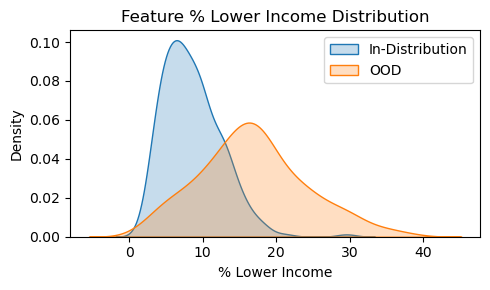

In [9]:
import seaborn as sns
for i in range(X.shape[1]):
    plt.figure(figsize=(5, 3))
    sns.kdeplot(X.iloc[in_dist_indices, i], label='In-Distribution', fill=True)
    sns.kdeplot(X.iloc[ood_indices, i], label='OOD', fill=True)
    plt.title(f'Feature {X_train.columns[i]} Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
train_preds = rf.predict(X_train_in)

min_index = np.argmin(train_preds)  # min val index
max_index = np.argmax(train_preds)  # max val index
mean_value = np.mean(train_preds)   # mean val 

closest_mean_index = np.argmin(np.abs(train_preds - mean_value))  # 


# Define function f(x) using rf.predict.
def f(x):
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf.predict(x_df)[0])

print("predcition",train_preds[[min_index, closest_mean_index, max_index]])
print("labels",y_train_in.iloc[[min_index, closest_mean_index, max_index]].values)


predcition [12.637 26.421 47.988]
labels [10.2 28.1 50. ]


In [11]:
X.columns

Index(['#Rooms', '% Pre-1940 Units', 'Dist to Biz', 'Stu-Tea Ratio',
       '% Lower Income'],
      dtype='object')

In [12]:
def f_in(x):
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf_in.predict(x_df)[0])

In [13]:
import sys
sys.path.append("../../")
from Approach import run_search_path
np.set_printoptions(suppress=True)  #
index = 0
print(X_train_in.columns)
prototypes = X_train_in.iloc[[min_index, closest_mean_index, max_index]].values
prototype_labels = y_train_in.iloc[[min_index, closest_mean_index, max_index]].values
error, avg_step_error = run_search_path(f_in, prototypes, prototype_labels, X_test_in.iloc[index].values,y_test_in.iloc[index])

Index(['#Rooms', '% Pre-1940 Units', 'Dist to Biz', 'Stu-Tea Ratio',
       '% Lower Income'],
      dtype='object')
X_proto [ 8.297  67.      2.4216 13.      7.44  ] org_proto 48.562000000000005 label 50.0
X_proto [ 8.297  67.      4.0317 13.     15.94  ] pred_prototype adj 48.58600000000001
X_target [ 5.782  71.7     4.0317 18.4    15.94  ] pred_target 21.219000000000005 label 19.8
Found a path:
Step 0: x = [ 8.297  67.      4.0317 13.     15.94  ], f(x) = 48.58600000000001
Step 1: x = [ 8.297  67.      4.0317 15.7    15.94  ], f(x) = 48.10900000000002
Step 2: x = [ 8.297  67.      4.0317 18.4    15.94  ], f(x) = 46.228
Step 3: x = [ 5.782  67.      4.0317 18.4    15.94  ], f(x) = 21.280000000000005
Step 4: x = [ 5.782  71.7     4.0317 18.4    15.94  ], f(x) = 21.219000000000005


In [55]:
y_ood = y.iloc[ood_indices]

In [ ]:
preds_ood = rf_in.predict(X.iloc[ood_indices])

In [59]:
preds_ood - y_ood

1      0.985
7     -6.460
8      2.804
9      2.067
10     5.936
       ...  
492   -4.500
500    4.957
503    4.475
504    5.370
505    9.750
Name: MEDV, Length: 252, dtype: float64

<AxesSubplot:xlabel='MEDV', ylabel='Count'>

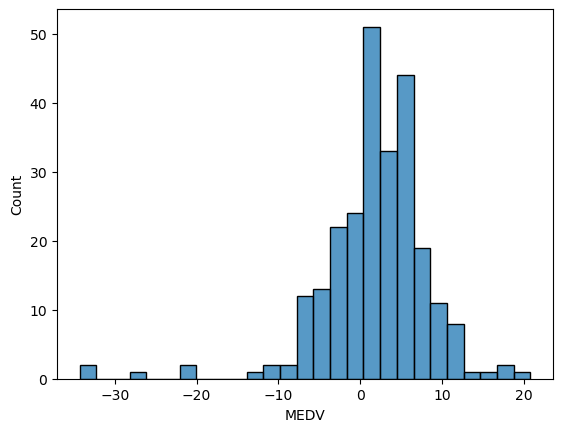

In [58]:
import seaborn as sns
sns.histplot(preds_ood - y_ood)

In [16]:
X_ood = X.iloc[ood_indices]
y_ood = y.iloc[ood_indices]
index = 13
import sys
sys.path.append("../../")
from Approach import run_search_path
np.set_printoptions(suppress=True)  #
print(X.columns)
prototypes = X_train_in.iloc[[min_index, closest_mean_index, max_index]].values
prototype_labels = y_train_in.iloc[[min_index, closest_mean_index, max_index]].values
error, avg_step_error = run_search_path(f_in, prototypes, prototype_labels, X_ood.iloc[index].values,y_ood.iloc[index])

Index(['#Rooms', '% Pre-1940 Units', 'Dist to Biz', 'Stu-Tea Ratio',
       '% Lower Income'],
      dtype='object')
X_proto [ 8.297  67.      2.4216 13.      7.44  ] org_proto 48.562000000000005 label 50.0
X_proto [ 8.297  67.      4.4546 13.     16.51  ] pred_prototype adj 48.54700000000002
X_target [ 5.599  85.7     4.4546 21.     16.51  ] pred_target 18.570000000000007 label 13.9
Found a path:
Step 0: x = [ 8.297  67.      4.4546 13.     16.51  ], f(x) = 48.54700000000002
Step 1: x = [ 8.297  76.35    4.4546 13.     16.51  ], f(x) = 45.00299999999999
Step 2: x = [ 8.297  76.35    4.4546 21.     16.51  ], f(x) = 42.95699999999997
Step 3: x = [ 5.599  76.35    4.4546 21.     16.51  ], f(x) = 18.558000000000007
Step 4: x = [ 5.599  85.7     4.4546 21.     16.51  ], f(x) = 18.570000000000007


[]

In [12]:
len(Errors) / len(X_test)

0.8627450980392157

In [13]:
np.array(each_step_avg_errs).mean() / preds.mean()

0.0957269374432681

In [10]:
from sklearn.cluster import KMeans
def dynamic_feature_filter(x_proto, x_target, num_samples=10, threshold=0.1):
    """
    classify features as low- or high-sensitivity by computing
    the variance of predictions when varying each feature, and then clustering 
    the variances using k-means.
    
    Parameters:
      x_proto: 1D numpy array for the prototype.
      x_target: 1D numpy array for the target.
      num_samples: Number of interpolation points per feature.
    
    Returns:
      variances: Array of variance values for each feature.
      low_variance_features: List of indices of features with low sensitivity.
      high_variance_features: List of indices of features with high sensitivity.
    """
    x_proto_adj = np.copy(x_proto)
    n_features = len(x_proto)
    variances = np.zeros(n_features)
    low_variance_features = []
    high_variance_features = []
    for i in range(n_features):
        # Generate interpolation values for the i-th feature.
        interp_vals = np.linspace(x_proto[i], x_target[i], num_samples)
        preds = []
        for val in interp_vals:
            x_temp = np.copy(x_proto)
            x_temp[i] = val  # Vary only the i-th feature.
            preds.append(f(x_temp))
        preds = np.array(preds)
        var_val = np.var(preds)
        variances[i] = var_val
        if var_val < threshold:
          x_proto_adj[i] = x_target[i]
          low_variance_features.append(i)
        else:
          high_variance_features.append(i)
    return x_proto_adj, variances, low_variance_features, high_variance_features


In [11]:
# Grid generation that fixes low-variance features.
def generate_grid_with_filter(x_proto_adj, x_target, partitions, low_variance_features):
    """
    For low-variance features, use a grid with a single point (the target).
    For high-variance features, generate a grid between x_proto_adj and x_target.
    """
    grid = []
    n_features = len(x_proto_adj)
    for i in range(n_features):
        if i in low_variance_features:
            grid.append(np.array([x_target[i]]))
        else:
            grid.append(np.linspace(x_proto_adj[i], x_target[i], partitions + 1))
    return grid

In [10]:
import numpy as np
import pandas as pd
import heapq
from collections import deque


def linear_approximation_error(f, x_start, x_end, f_start, f_end, num_samples=10):
    """
    compute accumulate absolute error
    """
    t_vals = np.linspace(0, 1, num_samples)
    accumulate_error = 0.0
    for t in t_vals:
        x_interp = x_start + t * (x_end - x_start)
        f_interp = f_start + t * (f_end - f_start)
        f_actual = f(x_interp)
        accumulate_error += abs(f_actual - f_interp)
    return accumulate_error 


In [11]:
from Methodology import a_star_search
def run_search_path(prototypes, X_target,partitions=2,max_steps=5):
    # Choose a test instance to explain (e.g., the first one)
    f_target = f(X_target)
    # Define multiple prototype candidates
    # Compute distances to X_target
    distances = np.linalg.norm(prototypes - X_target, axis=1)
    # Select the closest prototype
    closest_proto_index = np.argmin(distances)
    X_proto = prototypes[closest_proto_index]
    #### identify noise directions
    x_proto_adj, variances, low_variance_features, high_variance_features = dynamic_feature_filter(X_proto, X_target)
    grid = generate_grid_with_filter(x_proto_adj, X_target, partitions, low_variance_features)
    
    
    d = len(X_proto)
    initial_state = tuple([0] * d)
    initial_x = np.array([grid[i][0] for i in range(d)])  # 与 x_proto 应相同
    f_proto = f(initial_x)
    f_target = f(X_target)
    # identify the monotonic direction
    monotonic_increasing = (f_target >= f_proto)

    print("X_proto",X_proto, 'org_proto', f(X_proto))
    print("X_proto",x_proto_adj, 'pred_prototype adj', f(x_proto_adj))
    print("X_target",X_target,'pred_target', f_target)
    # result = dfs(initial_state, [initial_x], [f_proto], 0.0, grid, max_steps, monotonic_increasing, tol=1e-6)
    result = a_star_search(initial_state, initial_x, f_proto, X_target, f_target, grid, max_steps, monotonic_increasing)
    #


    if result is not None:
        print("Found a path:")
        for i, (x_val, fx_val) in enumerate(zip(result['path'], result['f_values'])):
            print(f"Step {i}: x = {x_val}, f(x) = {fx_val}")
        print("Cumulative error:", result['error'])
        return result['error']
    else:
        print("No path found.")
        return None
    

In [ ]:
def run_search_path(prototypes, X_target,partitions=2,max_steps=5):
    # Choose a test instance to explain (e.g., the first one)
    f_target = f(X_target)
    # Define multiple prototype candidates
    # Compute distances to X_target
    distances = np.linalg.norm(prototypes - X_target, axis=1)
    # Select the closest prototype
    closest_proto_index = np.argmin(distances)
    X_proto = prototypes[closest_proto_index]
    #### identify noise directions
    x_proto_adj, variances, low_variance_features, high_variance_features = dynamic_feature_filter(X_proto, X_target)
    grid = generate_grid_with_filter(x_proto_adj, X_target, partitions, low_variance_features)
    
    
    d = len(X_proto)
    initial_state = tuple([0] * d)
    initial_x = np.array([grid[i][0] for i in range(d)])  # 与 x_proto 应相同
    f_proto = f(initial_x)
    f_target = f(X_target)
    # identify the monotonic direction
    monotonic_increasing = (f_target >= f_proto)

    print("X_proto",X_proto, 'org_proto', f(X_proto))
    print("X_proto",x_proto_adj, 'pred_prototype adj', f(x_proto_adj))
    print("X_target",X_target,'pred_target', f_target)
    # result = dfs(initial_state, [initial_x], [f_proto], 0.0, grid, max_steps, monotonic_increasing, tol=1e-6)
    result = a_star_search(initial_state, initial_x, f_proto, X_target, f_target, f, grid, max_steps,monotonic_increasing)
    #


    if result is not None:
        print("Found a path:")
        for i, (x_val, fx_val) in enumerate(zip(result['path'], result['f_values'])):
            print(f"Step {i}: x = {x_val}, f(x) = {fx_val}")
        # print(len(result['path']))
        avg_error = result['error'] / (len(result['path']))
        return result['error'], avg_error 
    else:
        print("No path found.")
        return None
    

In [ ]:
# Prediction function using your random forest model.
def f(x):
    """
    Predicts the value for x using a random forest model.
    
    Args:
        x (np.ndarray): Input feature vector.
    
    Returns:
        float: Predicted value.
    """
    x_df = pd.DataFrame([x], columns=X.columns)
    return float(rf.predict(x_df)[0])

# Finite difference gradient approximation for f(x).
def grad_f(x, delta=1e-6):
    """
    Approximates the gradient of f at x using finite differences.
    
    Args:
        x (np.ndarray): Input feature vector.
        delta (float): Small perturbation used to compute the finite difference.
    
    Returns:
        np.ndarray: Approximated gradient vector.
    """
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_forward = np.array(x, copy=True)
        x_backward = np.array(x, copy=True)
        x_forward[i] += delta
        x_backward[i] -= delta
        grad[i] = (f(x_forward) - f(x_backward)) / (2 * delta)
    return grad

def baseline2run(prototypes, X_target, avg_abs_pred, p, max_steps=5, tol=1e-6):
    """
    Baseline 2: Gradient Descent-Based Search using a finite difference approximation.
    
    This function starts from the prototype that is closest to the target and performs
    gradient descent with an update rule:
    
        x_{t+1} = x_t - (1/p) * grad_f(x_t)
    
    The process stops when the current point is within a tolerance of X_target or after a
    maximum number of steps.
    
    Args:
        prototypes (np.ndarray): Array of prototype instances.
        X_target (np.ndarray): Target instance.
        avg_abs_pred (float): Average absolute prediction value for normalization.
        p (float): Parameter that scales the gradient step (step size is 1/p).
        max_steps (int): Maximum number of gradient descent steps.
        tol (float): Tolerance for convergence toward X_target.
    
    Returns:
        tuple: (raw_cumulative_error, normalized_cumulative_error)
    """
    # Find the prototype closest to the target.
    distances = np.linalg.norm(prototypes - X_target, axis=1)
    closest_proto_index = np.argmin(distances)
    X_proto = prototypes[closest_proto_index]
    
    f_target = f(X_target)
    path = [X_proto.copy()]
    f_values = [f(X_proto)]
    x_current = X_proto.copy()
    
    for step in range(max_steps):
        # Approximate the gradient at the current point.
        grad = grad_f(x_current)
        # Update the current point.
        x_new = x_current - (1 / p) * grad
        path.append(x_new.copy())
        f_values.append(f(x_new))
        
        # Check if the new point is close enough to the target.
        if np.linalg.norm(x_new - X_target) < tol:
            break
        
        x_current = x_new
    
    raw_cumulative_error = sum(abs(val - f_target) for val in f_values)
    normalized_cumulative_error = raw_cumulative_error / avg_abs_pred
    
    print("Gradient Descent-Based Search (Baseline 2) Path:")
    for i, (x_val, fx_val) in enumerate(zip(path, f_values)):
        print(f"Step {i}: x = {x_val}, f(x) = {fx_val}")
    print("Raw Cumulative Error:", raw_cumulative_error)
    print("Normalized Cumulative Error:", normalized_cumulative_error)
    
    return raw_cumulative_error, normalized_cumulative_error

prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
Norm_Errors= []
No_path_index = []
for i in range(len(X_test)):
    error, norm_error = baseline2run(prototypes,X_test.iloc[i].values,preds.mean(),2)
    print("error:",i, error)
    if error is not None:
        Errors.append(error)
        Norm_Errors.append(norm_error)
    else:
        No_path_index.append(i) 
        
print(np.array(Norm_Errors).mean())

In [45]:
prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
Norm_Errors= []
No_path_index = []
for i in range(len(X_test)):
    error, norm_error = baseline_one_step(prototypes,f,X_test.iloc[i].values,preds.mean())
    print("error:",i, error)
    if error is not None:
        Errors.append(error)
        Norm_Errors.append(norm_error)
    else:
        No_path_index.append(i) 

Raw Cumulative Error: 4.064873684210504
error: [0.         0.40304211 0.81308421 0.91012632 0.30016842 0.28521053
 0.24625263 0.30270526 0.49366316 0.31062105]
Normalized Cumulative Error: 0.1912378824435887
error: 0 4.064873684210504
Raw Cumulative Error: 11.888199999999973
error: [0.     1.2376 1.8122 0.8758 1.5734 1.215  1.6436 0.7078 0.6402 2.1826]
Normalized Cumulative Error: 0.5592976241542004
error: 1 11.888199999999973
Raw Cumulative Error: 9.293515789473686
error: [0.         0.37050175 2.52100351 1.91350526 0.76700702 0.74149123
 1.35298947 1.04948772 0.24701404 0.33051579]
Normalized Cumulative Error: 0.4372269394098511
error: 2 9.293515789473686
Raw Cumulative Error: 3.8485052631578895
error: [0.         0.64483158 0.73166316 0.61449474 0.46132632 0.32015789
 0.11798947 0.17717895 0.16234737 0.61851579]
Normalized Cumulative Error: 0.18105851602674483
error: 3 3.8485052631578895
Raw Cumulative Error: 5.445414035087729
error: [0.         0.49651228 0.50702456 0.19246316 1.15

In [47]:
np.array(Norm_Errors).mean()

0.46441843376099956

In [38]:
prototypes[2]

array([  2.01019,   0.     ,  19.58   ,   0.     ,   0.605  ,   7.929  ,
        96.2    ,   2.0459 ,   5.     , 403.     ,  14.7    ,   3.7    ])

In [15]:
X_test.iloc[2].values

array([1.0574e-01, 0.0000e+00, 2.7740e+01, 0.0000e+00, 6.0900e-01,
       5.9830e+00, 9.8800e+01, 1.8681e+00, 4.0000e+00, 7.1100e+02,
       2.0100e+01, 1.8070e+01])

In [37]:
# Given data points
X_proto = prototypes[2]
X_target = X_test.iloc[10].values
y_proto = 6.41
y_target = 16.65

# Number of interpolation points
num_points = 3

# Number of interpolation points
num_points = 3

# Generate interpolation points for X
X_interp = np.linspace(X_proto, X_target, num_points)

# Perform linear interpolation for y
y_interp = np.linspace(y_proto, y_target, num_points)
pred2 = rf.predict(X_interp)
abs(pred2 - y_interp).mean()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


20.776666666666667

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


0.1513333333333371

In [21]:
y_interp

array([ 6.41      ,  7.54777778,  8.68555556,  9.82333333, 10.96111111,
       12.09888889, 13.23666667, 14.37444444, 15.51222222, 16.65      ])

In [ ]:
error = run_search_path(prototypes,X_test.iloc[i].values)

In [ ]:
run_search_path

In [36]:
Norm_Errors

[0.0,
 0.37314631600148257,
 0.6167476142375484,
 0.07725550066802644,
 0.5997952095642686,
 0.033340251929135756,
 0.2598793704385311,
 0.39286923392695017,
 0.49246134426778987,
 0.058274871198808004,
 1.5708966961398838,
 0.2598950525890175,
 0.16047544590349877,
 0.04892830951030258,
 0.10893867202934729,
 1.8071848848668757,
 1.395591163261952,
 0.058233052130850955,
 1.1427426236237765,
 0.4661885148234754,
 0.009754297601092437,
 0.013037094435757927,
 0.37101877091914354,
 0.4765753258274259,
 0.37346518639465726,
 0.4783474088321243,
 0.04699940500076098,
 0.4562408040330805,
 0.2149134176172035,
 0.0815785468181372,
 0.3069049123567654,
 0.029121753448922667,
 1.7875926515287799,
 0.8485350257756138,
 0.3496701367268265,
 1.4440646904082122,
 0.4280913439141718,
 0.061829491975197666,
 0.23598500048430077,
 0.011244101897080173,
 0.26784590288444093,
 0.26160440699177717,
 1.2502594473425697,
 0.13923658676457254,
 0.011134326843690706,
 0.4499208973880004,
 1.820755172419097

In [37]:
prototypes = X_train.iloc[[min_index, closest_mean_index, max_index]].values
Errors = []
Norm_Errors= []
No_path_index = []
for i in range(95,len(X_test)):
    error, norm_error = run_search_path(prototypes,X_test.iloc[i].values, preds.mean())
    print("error:",i, error)
    if error is not None:
        Errors.append(error)
        Norm_Errors.append(norm_error)
    else:
        No_path_index.append(i) 

Raw Cumulative Error: 21.778444444444446
Normalized Cumulative Error: 1.024598529260279
error: 95 21.778444444444446
Raw Cumulative Error: 40.84555555555555
Normalized Cumulative Error: 1.9216384464831235
error: 96 40.84555555555555
Raw Cumulative Error: 8.49944444444445
Normalized Cumulative Error: 0.39986870042633943
error: 97 8.49944444444445
Raw Cumulative Error: 5.937666666666702
Normalized Cumulative Error: 0.2793461465727599
error: 98 5.937666666666702
Raw Cumulative Error: 7.020222222222225
Normalized Cumulative Error: 0.33027654396152656
error: 99 7.020222222222225
Raw Cumulative Error: 1.5813333333333226
Normalized Cumulative Error: 0.07439612189643272
error: 100 1.5813333333333226
Raw Cumulative Error: 0.7875555555555671
Normalized Cumulative Error: 0.037051694210365825
error: 101 0.7875555555555671


In [38]:
np.array(Norm_Errors).mean()

0.5810251689729753

In [33]:
Norm_Errors

[0.0,
 0.37314631600148257,
 0.6167476142375484,
 0.07725550066802644,
 0.5997952095642686,
 0.033340251929135756,
 0.2598793704385311,
 0.39286923392695017,
 0.49246134426778987,
 0.058274871198808004,
 1.5708966961398838,
 0.2598950525890175,
 0.16047544590349877,
 0.04892830951030258,
 0.10893867202934729,
 1.8071848848668757,
 1.395591163261952,
 0.058233052130850955,
 1.1427426236237765,
 0.4661885148234754,
 0.009754297601092437,
 0.013037094435757927,
 0.37101877091914354,
 0.4765753258274259,
 0.37346518639465726,
 0.4783474088321243,
 0.04699940500076098,
 0.4562408040330805,
 0.2149134176172035,
 0.0815785468181372,
 0.3069049123567654,
 0.029121753448922667,
 1.7875926515287799,
 0.8485350257756138,
 0.3496701367268265,
 1.4440646904082122,
 0.4280913439141718,
 0.061829491975197666,
 0.23598500048430077,
 0.011244101897080173,
 0.26784590288444093,
 0.26160440699177717,
 1.2502594473425697,
 0.13923658676457254,
 0.011134326843690706,
 0.4499208973880004,
 1.820755172419097

<AxesSubplot:ylabel='Count'>

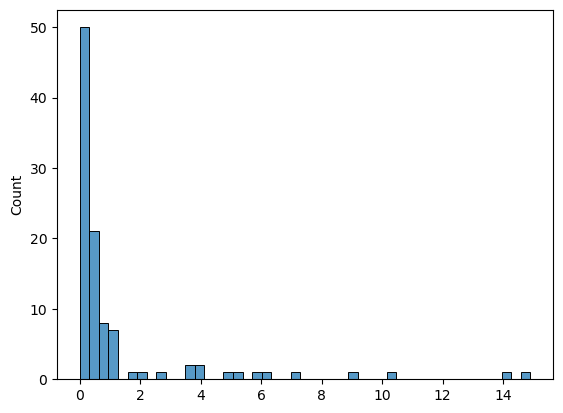

In [18]:
import seaborn as sns
sns.histplot(Errors)

In [19]:
len(X_test)

102

In [20]:
len(Errors)

102

In [21]:
93/102

0.9117647058823529

In [22]:
np.array(Errors).mean()

1.2353106706245467

In [23]:
1.34 / preds.mean()

0.06304224494596576

In [24]:
len(X_train)

404

In [25]:
len(X_test)

102

In [26]:
len(X_train.columns)

12